In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline


from bs4 import BeautifulSoup
import requests
import time, os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

import pandas as pd


In [2]:
def get_data(week_nums):
    url = 'https://www.baseball-reference.com/teams/NYY/{}.shtml'
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        df = pd.read_html(file_url)[0]
        df['YEAR'] = week_num
        dfs.append(df)
        
    return pd.concat(dfs)
        
week_nums = range(1960,2019)
yankees_df = get_data(week_nums)

In [3]:
yankees_df.to_pickle("./dummy.pkl")

# Cleaning the pinstripes #

In [4]:
yankees_df.reset_index(inplace= True, drop = True)
mask_1 = yankees_df['Age'] != 'Age'


In [5]:
yankees_df = yankees_df[mask_1]


In [6]:
mask_2 = yankees_df.Rk.isna()

In [7]:
yankees_df = yankees_df[~mask_2]

In [8]:
yankees_df.Pos.value_counts()

P     1149
C      185
OF     131
DH     128
1B     127
3B     116
LF     110
SS     106
RF     101
2B      96
CF      85
IF      70
UT      61
MI      20
CI       9
Name: Pos, dtype: int64

In [9]:
yankees_df.shape

(2504, 29)

In [10]:
yankees_df = yankees_df[yankees_df['Pos'] != 'P']

In [11]:
yankees_df.shape

(1355, 29)

In [12]:

yankees_df[['Age','G','PA','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO','BA','OBP','SLG','OPS','OPS+',
                 'TB','GDP','HBP','SH','SF','IBB']] = yankees_df[['Age','G','PA','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO','BA','OBP','SLG','OPS','OPS+',
                 'TB','GDP','HBP','SH','SF','IBB']].apply(pd.to_numeric)


In [13]:
yankees_df.rename(columns={'2B':'D','3B':'T'},inplace= True)

# Sorting, Grouping, Predict Column #

In [14]:
yankees_df_train = yankees_df.sort_values(['Name','YEAR'])

In [15]:
yankees_df_train['HR_PREDICT'] = yankees_df_train.groupby(['Name']).HR.shift(-1).to_list()

In [16]:
yankees_df_train[['Name','YEAR','HR','HR_PREDICT', 'Age']]

,Name,YEAR,HR,HR_PREDICT,Age
1973,Aaron Boone,2003,6,NaN,30
2142,Aaron Guiel*,2006,4,NaN,33
2703,Aaron Hicks#,2016,8,15.0,26
2766,Aaron Hicks#,2017,15,27.0,27
2819,Aaron Hicks#,2018,27,NaN,28
...,...,...,...,...,...
97,Yogi Berra*,1962,10,8.0,37
139,Yogi Berra*,1963,8,NaN,38
2587,Zelous Wheeler,2014,2,NaN,27
2522,Zoilo Almonte#,2013,1,1.0,24


## more cleaning ##

In [17]:
yankees_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1355 entries, 1973 to 2588
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rk          1355 non-null   object 
 1   Pos         1345 non-null   object 
 2   Name        1355 non-null   object 
 3   Age         1355 non-null   int64  
 4   G           1355 non-null   int64  
 5   PA          1355 non-null   int64  
 6   AB          1355 non-null   int64  
 7   R           1355 non-null   int64  
 8   H           1355 non-null   int64  
 9   D           1355 non-null   int64  
 10  T           1355 non-null   int64  
 11  HR          1355 non-null   int64  
 12  RBI         1355 non-null   int64  
 13  SB          1355 non-null   int64  
 14  CS          1355 non-null   int64  
 15  BB          1355 non-null   int64  
 16  SO          1355 non-null   int64  
 17  BA          1343 non-null   float64
 18  OBP         1343 non-null   float64
 19  SLG         1343 non-nul

In [18]:
yankees_df_train[yankees_df_train.Pos.isnull()]

,Rk,Pos,Name,Age,G,PA,AB,R,H,D,...,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,YEAR,HR_PREDICT
316,24,NaN,Charlie Sands*,19,1,1,1,0,0,0,...,0.000,-100.0,0,0,0,0,0,0,1967,NaN
1270,23,NaN,Chris Chambliss*,39,1,1,1,0,0,0,...,0.000,-100.0,0,0,0,0,0,0,1988,NaN
793,20,NaN,Dell Alston*,25,3,3,3,0,0,0,...,0.000,-100.0,0,0,0,0,0,0,1978,NaN
526,18,NaN,Frank Tepedino*,24,8,8,8,0,0,0,...,0.000,-100.0,0,0,0,0,0,0,1972,NaN
2656,23,NaN,Gary Sanchez,22,2,2,2,0,0,0,...,0.000,-100.0,0,0,0,0,0,0,2015,20.0
60,16,NaN,Jesse Gonder*,25,15,15,12,2,4,1,...,0.883,144.0,5,1,0,0,0,1,1961,NaN
1221,27,NaN,Keith Hughes*,23,4,4,4,0,0,0,...,0.000,-100.0,0,0,0,0,0,0,1987,NaN
64,20,NaN,Lee Thomas*,25,2,2,2,0,1,0,...,1.000,175.0,1,0,0,0,0,0,1961,NaN
403,24,NaN,Nate Oliver,28,1,1,1,0,0,0,...,0.000,-100.0,0,0,0,0,0,0,1969,NaN
226,24,NaN,Pedro Gonzalez,27,7,6,5,0,2,1,...,1.000,182.0,3,0,0,1,0,0,1965,NaN


## even more ##

In [19]:
yankess_pinstripes_clean = yankees_df_train[~yankees_df_train.HR_PREDICT.isna()]

In [20]:
yankess_pinstripes_clean.shape

(818, 30)

In [21]:
yankess_pinstripes_clean.Pos.isnull().sum()

1

In [22]:
yankess_pinstripes_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 818 entries, 2703 to 2522
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rk          818 non-null    object 
 1   Pos         817 non-null    object 
 2   Name        818 non-null    object 
 3   Age         818 non-null    int64  
 4   G           818 non-null    int64  
 5   PA          818 non-null    int64  
 6   AB          818 non-null    int64  
 7   R           818 non-null    int64  
 8   H           818 non-null    int64  
 9   D           818 non-null    int64  
 10  T           818 non-null    int64  
 11  HR          818 non-null    int64  
 12  RBI         818 non-null    int64  
 13  SB          818 non-null    int64  
 14  CS          818 non-null    int64  
 15  BB          818 non-null    int64  
 16  SO          818 non-null    int64  
 17  BA          816 non-null    float64
 18  OBP         816 non-null    float64
 19  SLG         816 non-null 

In [23]:
yankess_pinstripes_clean[yankess_pinstripes_clean.isnull().any(axis = 1)]

,Rk,Pos,Name,Age,G,PA,AB,R,H,D,...,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,YEAR,HR_PREDICT
2656,23,NaN,Gary Sanchez,22,2,2,2,0,0,0,...,0.0,-100.0,0,0,0,0,0,0,2015,20.0
105,18,3B,Jake Gibbs*,23,2,0,0,2,0,0,...,NaN,NaN,0,0,0,0,0,0,1962,0.0
1596,22,C,Jorge Posada#,24,1,0,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,1995,0.0


In [24]:
yankess_pinstripes_clean.loc[yankess_pinstripes_clean.Name == 'Gary Sanchez','Pos'] = "C"

/Users/estebanzuniga/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [25]:
yankess_pinstripes_clean.dropna(inplace = True)

/Users/estebanzuniga/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


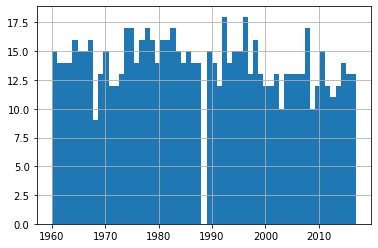

In [26]:
yankess_pinstripes_clean.YEAR.hist(bins = 59)

# Time series: Train set, Test set #

In [27]:
pinstripes_clean_tr = yankess_pinstripes_clean[yankess_pinstripes_clean.YEAR<(2007)]

In [28]:
pinstripes_clean_tr.shape

(674, 30)

In [29]:
# Very important!!!!! set year for how many season to withold. come up with obvious name
pinstripes_clean_test = yankess_pinstripes_clean[yankess_pinstripes_clean.YEAR >=(2007)] # test 

In [30]:
pinstripes_clean_test.shape

(142, 30)

In [31]:
pd.DataFrame(pinstripes_clean_test.YEAR.value_counts()).sort_index()

,YEAR
2007,13
2008,17
2009,10
2010,12
2011,15
2012,12
2013,11
2014,12
2015,14
2016,13


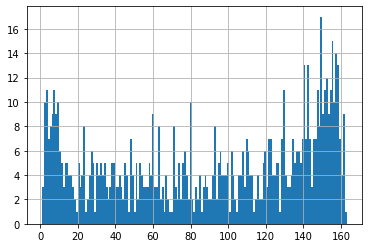

In [32]:
yankess_pinstripes_clean.G.hist(bins = yankess_pinstripes_clean.G.max())

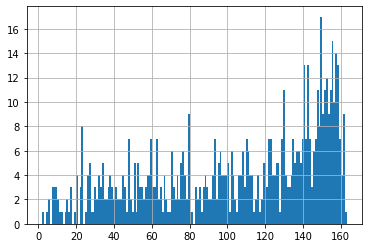

In [33]:
yankess_pinstripes_clean[yankess_pinstripes_clean.HR>0].G.hist(bins = yankess_pinstripes_clean.G.max())

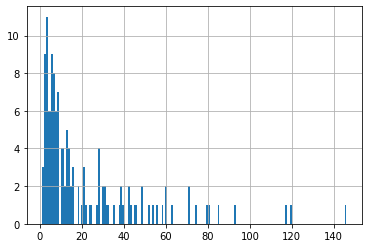

In [34]:
yankess_pinstripes_clean[yankess_pinstripes_clean.HR == 0].G.hist(bins = yankess_pinstripes_clean.G.max())

# setting up for R^2 score #

In [35]:
pinstripes_clean_tr.HR.mean()

9.584569732937686

In [36]:
formula = 'HR_PREDICT ~ '
for col in pinstripes_clean_tr.columns[3:-1]:
    formula = formula + col + ' + '
formula[:-2]

'HR_PREDICT ~ Age + G + PA + AB + R + H + D + T + HR + RBI + SB + CS + BB + SO + BA + OBP + SLG + OPS + OPS+ + TB + GDP + HBP + SH + SF + IBB + YEAR '

In [37]:
# STATSMODEL
y, X = patsy.dmatrices('HR_PREDICT ~ Age + HR + G +PA + AB + R + H + D + T + RBI + BB + SO + GDP + SF + IBB+ SLG', 
                       pinstripes_clean_tr, return_type="dataframe")


model = sm.OLS(y, sm.add_constant(X))


fit = model.fit()


fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             HR_PREDICT   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     57.33
Date:                Wed, 12 May 2021   Prob (F-statistic):          4.40e-113
Time:                        21:02:08   Log-Likelihood:                -2215.4
No. Observations:                 674   AIC:                             4465.
Df Residuals:                     657   BIC:                             4541.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.4341      1.959      4.815      0.000       5.587      13.281
Age           -0.2634      0.070     -3.784      0.000      -0.400      -0.127
HR             0.5347      0.087      6.177      0.000       0.365       0.705
G             -0.0416      0.023     -1.806      0.071      -0.087       0.004
PA            -0.1201      0.071     -1.681      0.093      -0.260       0.020
AB             0.1174      0.072      1.633      0.103      -0.024       0.259
R             -0.0674      0.040     -1.695      0.090      -0.145       0.011
H              0.0387      0.038      1.023      0.307      -0.036       0.113
D              0.0597      0.067      0.892      0.373      -0.072       0.191
T              0.0395      0.171      0.230      0.818      -0.297       0.376
RBI            0.0958      0.039      2.434      0.015       0.019       0.173
BB             0.1599      0.073      2.185      0.029       0.016       0.304
SO             0.0237      0.015      1.534      0.125      -0.007       0.054
GDP            0.0258      0.075      0.342      0.732      -0.122       0.174
SF            -0.0286      0.158     -0.181      0.856      -0.338       0.281
IBB           -0.1570      0.115     -1.370      0.171      -0.382       0.068
SLG            0.7181      2.501      0.287      0.774      -4.193       5.629
==============================================================================
Omnibus:                      121.734   Durbin-Watson:                   2.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              285.237
Skew:                           0.958   Prob(JB):                     1.15e-62
Kurtosis:                       5.547   Cond. No.                     6.16e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
y, X = patsy.dmatrices(formula[:-2], 
                       pinstripes_clean_tr, return_type="dataframe")


model = sm.OLS(y, sm.add_constant(X))


fit = model.fit()


fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             HR_PREDICT   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     38.07
Date:                Wed, 12 May 2021   Prob (F-statistic):          5.21e-107
Time:                        21:02:08   Log-Likelihood:                -2213.7
No. Observations:                 674   AIC:                             4477.
Df Residuals:                     649   BIC:                             4590.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6747     47.960     -0.014      0.989     -94.850      93.501
Age           -0.2766      0.072     -3.850      0.000      -0.418      -0.136
G             -0.0361      0.024     -1.520      0.129      -0.083       0.011
PA            -0.5602      0.688     -0.814      0.416      -1.911       0.791
AB             0.5577      0.688      0.811      0.418      -0.793       1.909
R             -0.0843      0.045     -1.892      0.059      -0.172       0.003
H             -0.0703      0.048     -1.451      0.147      -0.165       0.025
D             -0.0569      0.065     -0.871      0.384      -0.185       0.071
T             -0.1641      0.132     -1.239      0.216      -0.424       0.096
HR             0.1901      0.072      2.653      0.008       0.049       0.331
RBI            0.0931      0.041      2.286      0.023       0.013       0.173
SB             0.0350      0.047      0.740      0.460      -0.058       0.128
CS            -0.0410      0.136     -0.301      0.763      -0.308       0.226
BB             0.5916      0.687      0.862      0.389      -0.757       1.940
SO             0.0202      0.016      1.241      0.215      -0.012       0.052
BA            -6.5587     10.612     -0.618      0.537     -27.396      14.279
OBP          299.0780    504.388      0.593      0.553    -691.352    1289.508
SLG          294.3390    504.499      0.583      0.560    -696.309    1284.987
OPS         -293.1749    504.342     -0.581      0.561   -1283.515     697.165
TB             0.1148      0.033      3.448      0.001       0.049       0.180
GDP            0.0378      0.077      0.491      0.624      -0.113       0.189
HBP            0.5139      0.695      0.739      0.460      -0.851       1.879
SH             0.3596      0.690      0.522      0.602      -0.994       1.714
SF             0.4239      0.702      0.604      0.546      -0.954       1.802
IBB           -0.1493      0.116     -1.284      0.200      -0.378       0.079
YEAR           0.0051      0.024      0.209      0.834      -0.043       0.053
==============================================================================
Omnibus:                      118.613   Durbin-Watson:                   2.272
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              281.484
Skew:                           0.930   Prob(JB):                     7.53e-62
Kurtosis:                       5.561   Cond. No.                     1.00e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.81e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Train #

In [39]:
lr_tr = LinearRegression()

X_train = pinstripes_clean_tr[['Age','HR','G','PA','AB','R','H','D','T','RBI','BB','SO','GDP','SF','IBB']]
y_train = pinstripes_clean_tr['HR_PREDICT']

features = X_train.columns

lr_tr.fit(X_train, y_train)
lr_tr.score(X_train,y_train)

0.5826129879430991

In [40]:
lr_tr.intercept_

9.612821657096344

In [41]:

list(zip(features,lr_tr.coef_))

[('Age', -0.26145675209200214),
 ('HR', 0.5410752058726976),
 ('G', -0.040895751012002976),
 ('PA', -0.12022914066106563),
 ('AB', 0.11669842843968466),
 ('R', -0.0681210820878918),
 ('H', 0.04103252679286564),
 ('D', 0.06191604351501527),
 ('T', 0.044499510122927625),
 ('RBI', 0.09511921292026781),
 ('BB', 0.16028494324849232),
 ('SO', 0.023647716673559072),
 ('GDP', 0.025385960786087295),
 ('SF', -0.028170615783842935),
 ('IBB', -0.15783286313513875)]

# Val #

In [42]:
# First regression on test data ; lower  than the train data

X_test = pinstripes_clean_test[['Age','HR','G','PA','AB','R','H','D','T','RBI','BB','SO','GDP','SF','IBB']]
y_test = pinstripes_clean_test['HR_PREDICT']

test_features = X_test.columns

lr_tr.score(X_test,y_test)

0.40144591904666316

In [43]:
Y_hat = lr_tr.predict(X_test)

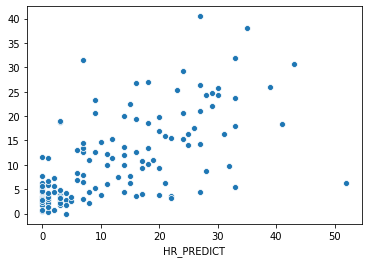

In [44]:
import seaborn as sns
sns.scatterplot(y_test,Y_hat)


In [45]:
resid = Y_hat-y_test
np.mean(abs(resid))

6.253476933137717

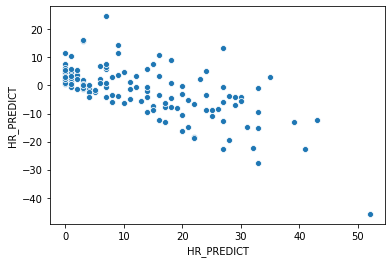

In [46]:
sns.scatterplot(y_test,resid)

# Scale #

In [47]:
# Standar Scalar. On train dataset
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
X_train_scaled= s.fit_transform(X_train)


lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr.score(X_train_scaled,y_train)

0.5826129879430991

In [48]:
# this is how you scale the test dataset
X_test_Scaled = s.transform(X_test)
lr.score(X_test_Scaled,y_test)


0.4014459190466627

In [49]:
lr.intercept_

9.114243323442134

In [50]:
list(zip(test_features,lr.coef_))

[('Age', -1.0863279252150124),
 ('HR', 5.525523963163893),
 ('G', -2.130193876836796),
 ('PA', -28.517299446291528),
 ('AB', 24.49303860088043),
 ('R', -2.3593441910120467),
 ('H', 2.5225688403471005),
 ('D', 0.7057562293910898),
 ('T', 0.09080706287366606),
 ('RBI', 3.2447814626829903),
 ('BB', 4.496046724791682),
 ('SO', 0.8150428805305757),
 ('GDP', 0.1524557645561667),
 ('SF', -0.07845602368083324),
 ('IBB', -0.5387267058640876)]

# Feature Engineering #

In [51]:
X2_train = pinstripes_clean_tr[['Age','HR','G','PA','AB','R','H','D','T','RBI','BB','SO','GDP','SF','IBB']].copy()

X2_train['HR2'] = X2_train['HR']**2
X2_train['BB2'] = X2_train['BB']**2 
X2_train['H2']  = X2_train['H']**2
X2_train['PA2'] = X2_train['PA']**.5

lrx2 = LinearRegression()




In [52]:
X2_train.columns

Index(['Age', 'HR', 'G', 'PA', 'AB', 'R', 'H', 'D', 'T', 'RBI', 'BB', 'SO',
       'GDP', 'SF', 'IBB', 'HR2', 'BB2', 'H2', 'PA2'],
      dtype='object')

In [53]:
lrx2.fit(X2_train, y_train)
lrx2.score(X2_train,y_train)

0.5886570299232599

In [54]:
X2_test = pinstripes_clean_test[['Age','HR','G','PA','AB','R','H','D','T','RBI','BB','SO','GDP','SF','IBB']].copy()

X2_test['HR2'] = X2_test['HR']**2
X2_test['BB2'] = X2_test['BB']**2
X2_test['H2']  = X2_test['H']**2
X2_test['PA2'] = X2_test['PA']**.5

In [55]:
X2_test.columns

Index(['Age', 'HR', 'G', 'PA', 'AB', 'R', 'H', 'D', 'T', 'RBI', 'BB', 'SO',
       'GDP', 'SF', 'IBB', 'HR2', 'BB2', 'H2', 'PA2'],
      dtype='object')

# Best Model #

In [56]:
lrx2.score(X2_test,y_test)

0.41816892636235503

# Final Product #

In [57]:
Y2_hat = lrx2.predict(X2_test)

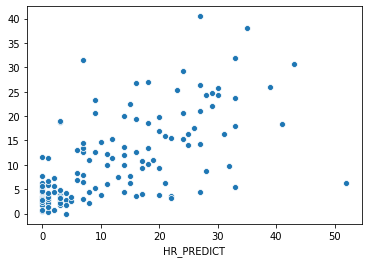

In [58]:
sns.scatterplot(y_test,Y_hat)

In [59]:
resid = Y_hat-y_test
np.mean(abs(resid))

6.253476933137717

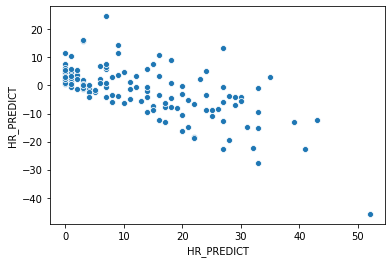

In [60]:
sns.scatterplot(y_test,resid)

# Regularization did not help#

In [63]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures

In [64]:
m = RidgeCV()
p = PolynomialFeatures(degree=2)
m.fit(p.fit_transform(X_train_scaled),y_train)
m.score(p.transform(X_train_scaled),y_train)

0.6514784737284101

In [65]:

m.score(p.transform(X_test_Scaled),y_test)

0.30072823943008453

In [66]:
from sklearn.preprocessing import PolynomialFeatures
p = PolynomialFeatures(degree=2)
x_train_poly = p.fit_transform(X_train)
lr.fit(x_train_poly,y_train)
lr.score(x_train_poly,y_train)

0.6792732383134212

Text(0.5, 1.0, 'Hits feature v Target ')

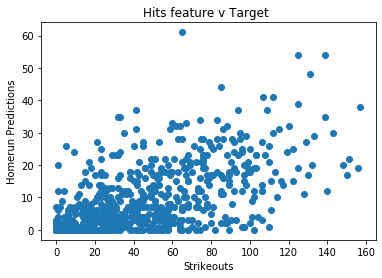

In [67]:
plt.scatter(pinstripes_clean_tr['SO'],y_train)
plt.xlabel('Strikeouts')
plt.ylabel('Homerun Predictions')
plt.title("Hits feature v Target ")



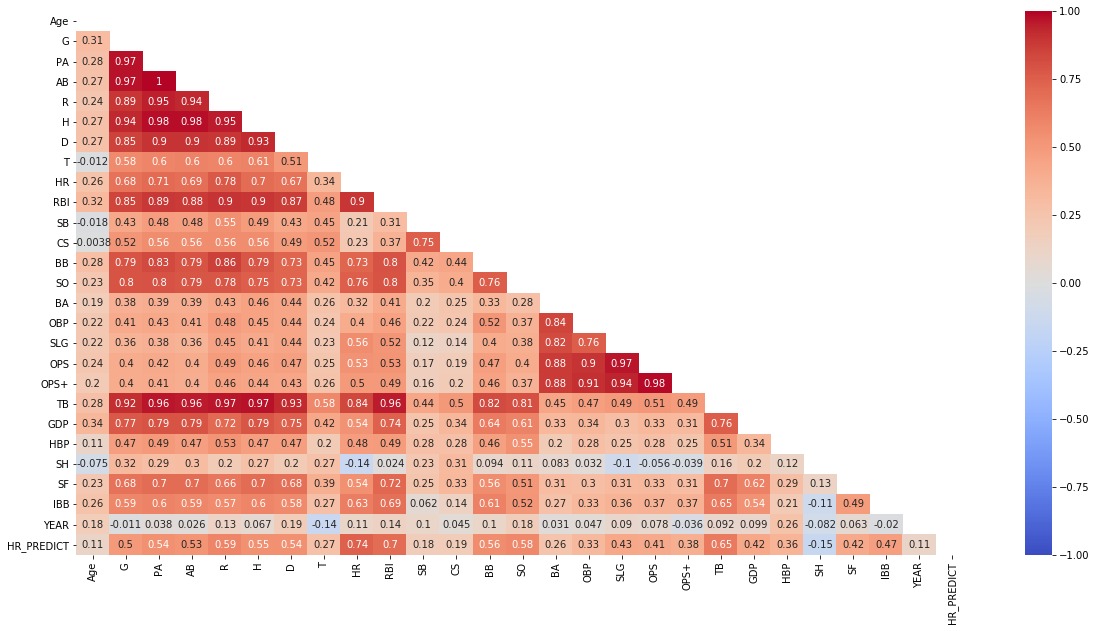

In [68]:
pincorr = pinstripes_clean_tr.corr()
mask_3 = np.zeros_like(pincorr, dtype=np.bool)
mask_3[np.triu_indices_from(mask_3)] = True


plt.figure(figsize=(20,10))
sns.heatmap(pinstripes_clean_tr.corr(),mask = mask_3, cmap="coolwarm", annot=True, vmin=-1, vmax=1);

In [ ]:
driver = webdriver.Chrome(chromedriver)
driver.get()

In [ ]:
driver.page_source[:1000]

In [ ]:
driver.quit()

In [ ]:

caldo_feo = BeautifulSoup(driver.page_source, 'html.parser')


In [ ]:
table = caldo_feo.body.find('table', id= 'team_batting').find('tbody')
table
rows = [row for row in table.find_all('tr')]
rows




#div_id_all_team_batting = body.find('div',id='all_team_batting')